In [1]:
import numpy as np
import scipy.fftpack as fft
import matplotlib.pyplot as plt
import cv2 as cv
import time
# from picamera import PiCamera
# from picamera.array import PiRGBArray
from jupyterthemes import jtplot

In [2]:
jtplot.reset()
# plt.switch_backend('Agg')
plt.style.use("bmh")
plt.rcParams["axes.axisbelow"] = True
plt.rcParams["text.usetex"] = True
plt.rcParams["font.family"] = "serif"
plt.rcParams["figure.figsize"] = (16/2, 9/2)
plt.rcParams["figure.dpi"] = 100
plt.rcParams["text.latex.preamble"] = [r"\usepackage{physics}"]

11/29

* laser-to-screen: 239 cm

* Trial 1
    - single slit: 0.04 mm
    - central maximum: 6 cm
    
* Trial 2
    - single slit 0.02 mm
    - central max 10.5 cm
    
* Trial 3
    - single slit 0.08 mm
    - central max 3.5 cm
    
* Trial 4
    - single slit 0.16 mm
    - central max 1.8 cm
    
* Trial 5
    - square
    
* Trial 6
    - circle diam 0.2mm
    
* Trial 7
    - circle diam 0.4mm
    
* Trial 8
    - double a=0.08mm, d=0.50mm
    
* Trial 9
    - double a=0.08mm, d=0.25mm

* Trial 10
    - double a=0.04mm, d=0.50mm

In [2]:
camera = PiCamera()

In [15]:
camera.resolution = (1280, 720)
camera.framerate = 15
camera.iso = 800
camera.shutter_speed = int(1/15 * 1e6)
rawCapture = PiRGBArray(camera, size=camera.resolution)
time.sleep(0.2)
for frame in camera.capture_continuous(rawCapture, format='bgr', use_video_port=True):
    image = frame.array
    cv.imshow('image', image)
    key = cv.waitKey(1) & 0xFF
    rawCapture.truncate(0)
    
    if key -- ord('s'):
        cv.imwrite('double-0.04-0.50.png', image)
    if key == ord('q'):
        break
cv.destroyAllWindows()

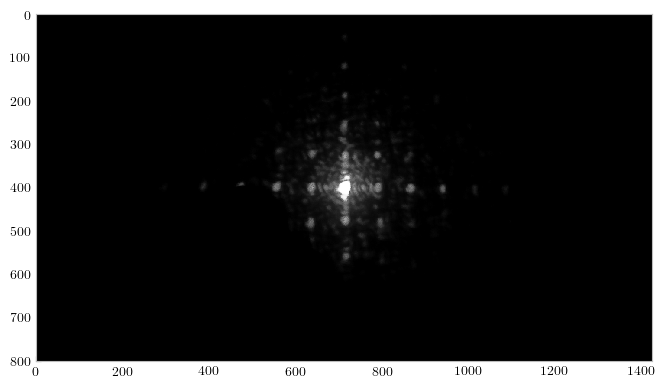

In [11]:
gray = cv.imread('square.png', 0)
plt.imshow(gray, 'gray')
plt.grid(0)
plt.show()

<IPython.core.display.Javascript object>


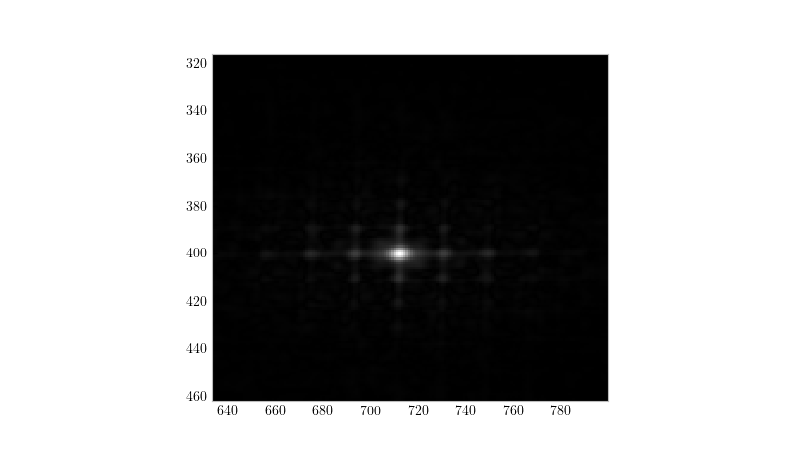

In [14]:
FZ = fft.fftshift(fft.fft2(gray))
plt.imshow(abs(FZ), 'gray')
plt.grid(0)
plt.show()